# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.
- Do not modify the random seed, as they are needed for reproducibility purpose.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [2]:
import random
import numpy as np
import torch
import torchvision


# Fix all random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: mps


In [3]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


### Example of a simple CNN model

In [4]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [5]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.6139
Epoch [2/10], Loss: 4.5809
Epoch [3/10], Loss: 4.5756
Epoch [4/10], Loss: 4.5896
Epoch [5/10], Loss: 4.5961
Epoch [6/10], Loss: 4.5979
Epoch [7/10], Loss: 4.6145
Epoch [8/10], Loss: 4.5321
Epoch [9/10], Loss: 4.5010
Epoch [10/10], Loss: 4.3955


In [6]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 3.37%


## Improved Approach

In [7]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

# ------------------------------------------------------
# 1) Data transforms
# ------------------------------------------------------
train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

test_transform = T.ToTensor()

# ------------------------------------------------------
# 2) Load full CIFAR-100 train set
# ------------------------------------------------------
full_train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=train_transform
)

# Create validation split (10% of training data)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Validation must NOT use augmentation
val_dataset.dataset.transform = test_transform

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=test_transform
)

# ------------------------------------------------------
# 3) DataLoaders
# ------------------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

Train samples: 45000
Val samples:   5000
Test samples:  10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------
# 3) Define Model
# ------------------------------------------------------

# Optional SE block (lightweight)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class DWConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_se=False):
        super().__init__()
        self.use_se = use_se

        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=3,
            stride=stride, padding=1, groups=in_channels, bias=False
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

        if use_se:
            self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        if self.use_se:
            x = self.se(x)
        return F.relu(x)

class MobileNetTiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            DWConvBlock(32, 64, stride=1, use_se=True),
            DWConvBlock(64, 128, stride=2, use_se=True),
            DWConvBlock(128, 128, stride=1),
            DWConvBlock(128, 256, stride=2, use_se=True),
            DWConvBlock(256, 256, stride=1),
            DWConvBlock(256, 512, stride=2, use_se=True),
            DWConvBlock(512, 512, stride=1),
            DWConvBlock(512, 512, stride=1, use_se=False),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(512, 100)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
model = MobileNetTiny().to(device)
print("Model parameters:", sum(p.numel() for p in model.parameters()))

Model parameters: 941284


In [ ]:
# ------------------------------------------------------
# 4) Define loss, optimizer, scheduler
# ------------------------------------------------------

model = MobileNetTiny().to(device)
print("Model parameters:", sum(p.numel() for p in model.parameters()))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

Model parameters: 941284


In [10]:
# ------------------------------------------------------
# 5) Helper function: compute accuracy
# ------------------------------------------------------
def compute_accuracy(loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = torch.max(logits, 1)
            total += y.size(0)
            correct += (preds == y).sum().item()
    return 100 * correct / total

# ------------------------------------------------------
# 6) Training loop WITH train + val accuracy
# ------------------------------------------------------
epochs = 55
train_acc = np.zeros(epochs)
val_acc = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # ---- Compute accuracies ----
    train_acc[epoch] = compute_accuracy(train_loader)
    val_acc[epoch]   = compute_accuracy(val_loader)

    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"Loss: {running_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc[epoch]:.2f}% | "
          f"Val Acc: {val_acc[epoch]:.2f}%")

Epoch 001/55 | Loss: 3.8607 | Train Acc: 13.84% | Val Acc: 12.56%
Epoch 002/55 | Loss: 3.0964 | Train Acc: 26.71% | Val Acc: 24.66%
Epoch 003/55 | Loss: 2.6441 | Train Acc: 33.24% | Val Acc: 29.18%
Epoch 004/55 | Loss: 2.3853 | Train Acc: 32.43% | Val Acc: 29.44%
Epoch 005/55 | Loss: 2.2289 | Train Acc: 42.95% | Val Acc: 40.06%
Epoch 006/55 | Loss: 2.1038 | Train Acc: 36.89% | Val Acc: 32.68%
Epoch 007/55 | Loss: 2.0203 | Train Acc: 45.48% | Val Acc: 40.30%
Epoch 008/55 | Loss: 1.9681 | Train Acc: 48.15% | Val Acc: 41.76%
Epoch 009/55 | Loss: 1.9052 | Train Acc: 45.99% | Val Acc: 40.74%
Epoch 010/55 | Loss: 1.8533 | Train Acc: 48.68% | Val Acc: 42.26%
Epoch 011/55 | Loss: 1.8244 | Train Acc: 51.25% | Val Acc: 45.38%
Epoch 012/55 | Loss: 1.7872 | Train Acc: 47.20% | Val Acc: 42.08%
Epoch 013/55 | Loss: 1.7559 | Train Acc: 46.35% | Val Acc: 40.78%
Epoch 014/55 | Loss: 1.7328 | Train Acc: 51.29% | Val Acc: 45.00%
Epoch 015/55 | Loss: 1.7003 | Train Acc: 47.28% | Val Acc: 40.24%
Epoch 016/

In [13]:
# Save weights and evaluate

torch.save(model.state_dict(), "mobilenet_tiny_cifar100.pth")

loaded_model = MobileNetTiny().to(device)
loaded_model.load_state_dict(torch.load("mobilenet_tiny_cifar100.pth", weights_only=True, map_location=device))

evaluate(loaded_model)


The model has 941284 parameters
Accuracy on the test set: 56.09%


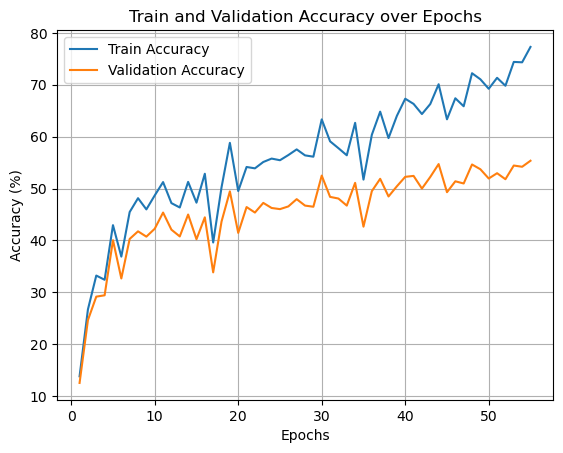

In [14]:
# plot train and val accuracy curves
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), train_acc, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()